<a href="https://colab.research.google.com/github/MarcosVeniciu/Producao-de-cafe-MG/blob/main/LSTM_Coffee_Production_Prediction_with_Machine_Learning_in_Minas_Gerais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# requeriment
#%capture
!pip cache purge
!mkdir -p ~/tmp_pip
!TMPDIR=~/tmp_pip pip install --no-cache-dir neuralforecast statsforecast optuna plotly scikit-learn lightning ipywidgets openpyxl nbformat

# Funções de suporte

In [6]:
from sklearn.metrics import r2_score, root_mean_squared_error
from neuralforecast.losses.pytorch import HuberLoss
from pytorch_lightning.loggers import CSVLogger
from sklearn.preprocessing import OneHotEncoder
from torch.optim.lr_scheduler import CyclicLR
from neuralforecast import NeuralForecast
from IPython.display import clear_output
from neuralforecast.models import LSTM
import plotly.graph_objects as go
from datetime import datetime
from torch.optim import AdamW
from pathlib import Path
import pandas as pd
import numpy as np
import zipfile
import optuna
import shutil
import math
import time
import glob
import os

In [7]:
def train_model(
    train_df,
    test_df,
    exog_list,
    h: int,
    input_size: int,
    output_dir: str = './model',
    steps: int = 500,
    default_params: dict = None,
    n_trials: int = 20,
    val_df=None,
    freqencia: str = "YE"  # Frequência dos dados, por exemplo, "YE" para Final do ano, ME para Final do mês, etc.
):
    """
    Treina um modelo LSTM usando os parâmetros em default_params.
    - Se default_params for um dict, executa o treinamento com esses parâmetros.
    - Se default_params for None, exibe um aviso e não prossegue com o treinamento.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Verifica se os parâmetros foram fornecidos
    if default_params is None:
        print("Você deve informar os parametros a serem usados no treinamento!")
        return None

    # Branch sem Optuna: usa os parâmetros fornecidos
    model = LSTM(
        h=h,
        input_size=input_size,
        **default_params
    )
    nf = NeuralForecast(models=[model], freq=freqencia)
    nf.fit(df=train_df)
    nf.save(path=output_dir, overwrite=True, save_dataset=False)

    # Empacota os artefatos em um ZIP
    zip_path = Path(output_dir) / "model_bundle.zip"
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(output_dir):
            for f in files:
                if f != zip_path.name:
                    zf.write(os.path.join(root, f), arcname=f)
    print(f"\nModel artifacts zipped to {zip_path}")

In [8]:
def rolling_evaluation(model, full_df: pd.DataFrame, test_df: pd.DataFrame, context_size: int, horizon: int, inteiro=True) -> pd.DataFrame:
  # --- Preparação inicial ---
  # Garantir que as datas estejam em datetime e ordenar os dataframes
  full_df = full_df.copy()
  test_df = test_df.copy()
  full_df['ds'] = pd.to_datetime(full_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])

  # Todos os valores exclusivos de datas no período de teste, ordenados
  test_dates = sorted(test_df['ds'].unique())
  # Determina quantas janelas de previsão iremos executar
  n_dates = len(test_dates)
  n_loops = math.ceil(n_dates / horizon)

  all_forecasts = []

  # --- Loop de previsão por janelas de tamanho `horizon` ---
  for j in range(n_loops):
      # Identifica o bloco de datas que compõem o horizonte atual
      date_chunk = test_dates[j * horizon : (j + 1) * horizon]
      start_date = date_chunk[0]  # Data de início dessa janela de previsão

      print(f"\nExecutando window {j+1}/{n_loops}: datas {date_chunk[0].date()} a {date_chunk[-1].date()}")
      val_df = test_df[test_df['ds'].isin(date_chunk)] # possui os dados de teste para a janela atual
      history_df = full_df[full_df['ds'] < start_date] # possui os dados historicos para a janela atual
      futr_df = val_df.drop(columns=["y"]).copy()

      # Realiza a predição para a janela atual
      forecasts_df = model.predict(
        df=history_df,         # Dados históricos (para contexto)
        futr_df=futr_df      # Valores futuros das variáveis exógenas
      )
      # Combinar previsões com valores reais do teste
      evaluation_df = forecasts_df.merge(
          val_df[["unique_id", "ds", "y"]],
          on=["unique_id", "ds"]
      )
      evaluation_df['y'] = np.expm1(evaluation_df['y']) # Inverte a transformação log1p aplicada nos dados
      evaluation_df['LSTM'] = np.expm1(evaluation_df['LSTM']) # Inverte a transformação log1p aplicada nas previsões

      if inteiro:
        evaluation_df['LSTM'] = evaluation_df['LSTM'].round().astype(int)
        evaluation_df['y'] = evaluation_df['y'].round().astype(int)

      all_forecasts.append(evaluation_df)

  # --- Concatena todas as previsões obtidas ---
  forecasts_df = pd.concat(all_forecasts, ignore_index=True)
  forecasts_df = calcular_diferenca_percentual(forecasts_df)

  return forecasts_df

In [9]:
def generate_steps_options():
  # Intervalos com granularidade fina no início
  step_1 = list(range(500, 1001, 100))
  step_2 = list(range(1100, 2001, 200))
  step_3 = list(range(2200, 5001, 400))

  steps_options = step_1 + step_2 + step_3
  return sorted(steps_options)

In [10]:
## WMAPE (Weighted MAPE)
def wmape(actual, predicted):
  return np.sum(np.abs(predicted - actual)) / np.sum(np.abs(actual))

In [11]:
def calcula_diferenca_pct(row):
    if row['y_pred'] == "-" or row['y_pred'] is None:
        return "-"
    try:
        y_pred_float = float(row['y_pred'])
        y_real = float(row['y'])
        # Evita divisão por zero
        if y_real == 0:
            return "-"
        # Calcula diferença percentual absoluta
        diff_pct = abs((y_pred_float - y_real) / y_real) * 100
        return round(diff_pct, 2)
    except:
        return "-"

In [12]:
def calcular_diferenca_percentual(df):
    """
    Calcula a diferença percentual entre valores preditos (LSTM) e reais (y)
    e retorna um novo DataFrame com a coluna adicional 'diferença_%'

    Fórmula: ((LSTM - y) / y) * 100

    Interpretação:
    - Valor negativo: previsão subestimada (LSTM < y)
    - Valor positivo: previsão superestimada (LSTM > y)

    Parâmetros:
    df (DataFrame): DataFrame com colunas 'y' e 'LSTM'

    Retorna:
    DataFrame: Novo DataFrame com a coluna 'diferença_%' adicionada
    """
    # Cria uma cópia do DataFrame para não modificar o original
    df_novo = df.copy()

    # Calcula a diferença percentual com sinal correto
    df_novo['diferença_%'] = round(((df_novo['LSTM'] - df_novo['y']) / df_novo['y']) * 100, 2)

    return df_novo

In [13]:
import pandas as pd
import plotly.graph_objects as go
import os

def plot_losses(csv_path): 
    # Carrega o DataFrame
    df = pd.read_csv(csv_path)

    # Cria a figura
    fig = go.Figure()

    # Plot Train Loss por época (filtra NaN)
    if "train_loss_epoch" in df.columns:
        mask = df["train_loss_epoch"].notna()
        if mask.any():
            fig.add_trace(go.Scatter(
                x=df.loc[mask, "epoch"],
                y=df.loc[mask, "train_loss_epoch"],
                mode='lines+markers',
                name='Train Loss (Epoch)',
                line=dict(color='blue')
            ))
        else:
            print("Sem dados na coluna 'train_loss_epoch'.")
    else:
        print("Atenção: coluna 'train_loss_epoch' não encontrada. Pulando plot de treino.")

    # Plot Valid Loss (filtra NaN)
    if "valid_loss" in df.columns:
        mask = df["valid_loss"].notna()
        if mask.any():
            fig.add_trace(go.Scatter(
                x=df.loc[mask, "epoch"],
                y=df.loc[mask, "valid_loss"],
                mode='lines+markers',
                name='Valid Loss',
                line=dict(color='orange')
            ))
        else:
            print("Sem dados na coluna 'valid_loss'.")
    else:
        print("Atenção: coluna 'valid_loss' não encontrada. Pulando plot de validação.")

    # Checa se tem dados
    if not fig.data:
        print("Nenhuma curva disponível para plotar.")
        return

    # Layout do gráfico
    fig.update_layout(
        title="Loss por Época",
        xaxis_title="Época",
        yaxis_title="Loss",
        legend=dict(x=0.01, y=0.99),
        template="plotly_white"
    )

    # Mostra o gráfico
    fig.show()

    # Salva o gráfico na mesma pasta do CSV
    output_folder = os.path.dirname(csv_path)
    output_path = os.path.join(output_folder, "grafico_loss.html")

    fig.write_html(output_path)
    print(f"Gráfico salvo em: {output_path}")

# Preparar dataset

In [14]:
dataset = pd.read_csv('Dataset/V17/dataset_v17.csv')
print(f"Total de dados: {len(dataset)}")

Total de dados: 2054


In [15]:
# Definindo as colunas categóricas
cat_features = ['Mesorregião', "Municipio"]

# Gerando a lista de colunas numéricas (todas as colunas exceto as categóricas)
num_features = [col for col in dataset.columns if col not in cat_features]

# Seleciona as colunas
dataset = dataset[num_features + cat_features].copy()
# Formatando a saída conforme solicitado
print("Num Features:")
for feature in num_features:
    print(f"    - {feature}")

print("\nCat Features:")
for feature in cat_features:
    print(f"    - {feature}")

Num Features:
    - target
    - Municipio_id
    - Ano
    - altitude
    - precipitacao (mm) 01
    - precipitacao (mm) 02
    - precipitacao (mm) 03
    - precipitacao (mm) 04
    - precipitacao (mm) 05
    - precipitacao (mm) 06
    - precipitacao (mm) 07
    - precipitacao (mm) 08
    - precipitacao (mm) 09
    - precipitacao (mm) 10
    - precipitacao (mm) 11
    - precipitacao (mm) 12
    - temperatura maxima (ºC) 01
    - temperatura maxima (ºC) 02
    - temperatura maxima (ºC) 03
    - temperatura maxima (ºC) 04
    - temperatura maxima (ºC) 05
    - temperatura maxima (ºC) 06
    - temperatura maxima (ºC) 07
    - temperatura maxima (ºC) 08
    - temperatura maxima (ºC) 09
    - temperatura maxima (ºC) 10
    - temperatura maxima (ºC) 11
    - temperatura maxima (ºC) 12
    - temperatura minima (ºC) 01
    - temperatura minima (ºC) 02
    - temperatura minima (ºC) 03
    - temperatura minima (ºC) 04
    - temperatura minima (ºC) 05
    - temperatura minima (ºC) 06
    - tempe

- Log-transform em Área colhida, Quantidade (em mil toneladas) e Valor da produção.

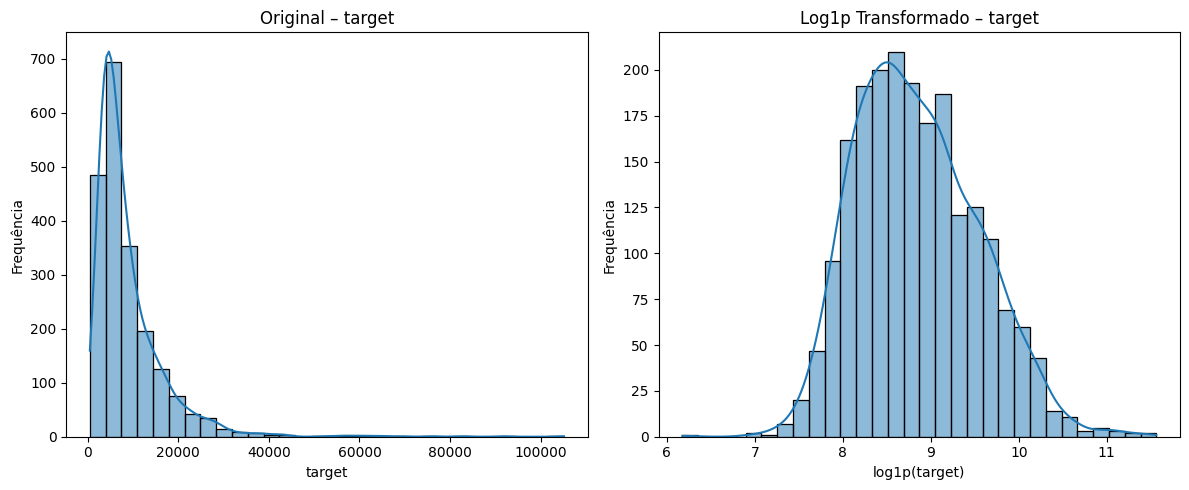

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# copie a série original antes de qualquer transformação
original = dataset['target'].copy()
# aplique log1p no original
transformed = np.log1p(original)

# monta o gráfico
plt.figure(figsize=(12, 5))

# distribuição original
plt.subplot(1, 2, 1)
sns.histplot(original, kde=True, bins=30)
plt.title('Original – target')
plt.xlabel('target')
plt.ylabel('Frequência')

# distribuição log1p
plt.subplot(1, 2, 2)
sns.histplot(transformed, kde=True, bins=30)
plt.title('Log1p Transformado – target')
plt.xlabel('log1p(target)')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [17]:
log_cols = [
  'Área colhida (Hectares)',
  'target',
  'Valor da produção (Mil Reais)'
]

# Verifica quais colunas de log_cols estão presentes no dataset
existing_log_cols = [col for col in log_cols if col in dataset.columns]

# Mostra as colunas que serão transformadas
print("Colunas encontradas para aplicar log1p:", existing_log_cols)

# Aplica log1p apenas nas colunas presentes
dataset[existing_log_cols] = dataset[existing_log_cols].apply(lambda x: np.log1p(x))

Colunas encontradas para aplicar log1p: ['target']


In [18]:
# Renomeando as colunas para o formato esperado pelo NeuralForecast
dataset = dataset.rename(columns={
  "Municipio_id": "unique_id",
  "Ano": "ds",
  "target": "y"
})
dataset = dataset.sort_values(by=["unique_id", "ds"]).reset_index(drop=True)
# Converte o ano inteiro para uma string no formato 'YYYY-12-31' (último dia do ano)
dataset['ds'] = pd.to_datetime(dataset['ds'].astype(str) + '-12-31')

In [19]:
# Inicializa o OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Lista de colunas categóricas para codificar
colunas_categoricas = ["Mesorregião", "Municipio"]

# Aplica o encoder nas colunas selecionadas
encoded_data = encoder.fit_transform(dataset[colunas_categoricas])

# Cria um DataFrame com os nomes das colunas codificadas
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(colunas_categoricas),
    index=dataset.index  # Mantém o mesmo índice
)

# Concatena o DataFrame codificado com o dataset original
dataset = pd.concat([dataset.drop(columns=colunas_categoricas), encoded_df], axis=1)

In [20]:
#Use-o caso queira treinar sem o uso das variaveis exogenas!
#dataset= dataset[["ds", "y", "unique_id"]].copy()
#dataset.info()

In [21]:
exog_list = [col for col in dataset.columns.tolist() if col not in ["ds", "y", "unique_id"]]
print(f"Variaveis Exogenas:")
for col in exog_list:
  print(f" - {col}")

Variaveis Exogenas:
 - altitude
 - precipitacao (mm) 01
 - precipitacao (mm) 02
 - precipitacao (mm) 03
 - precipitacao (mm) 04
 - precipitacao (mm) 05
 - precipitacao (mm) 06
 - precipitacao (mm) 07
 - precipitacao (mm) 08
 - precipitacao (mm) 09
 - precipitacao (mm) 10
 - precipitacao (mm) 11
 - precipitacao (mm) 12
 - temperatura maxima (ºC) 01
 - temperatura maxima (ºC) 02
 - temperatura maxima (ºC) 03
 - temperatura maxima (ºC) 04
 - temperatura maxima (ºC) 05
 - temperatura maxima (ºC) 06
 - temperatura maxima (ºC) 07
 - temperatura maxima (ºC) 08
 - temperatura maxima (ºC) 09
 - temperatura maxima (ºC) 10
 - temperatura maxima (ºC) 11
 - temperatura maxima (ºC) 12
 - temperatura minima (ºC) 01
 - temperatura minima (ºC) 02
 - temperatura minima (ºC) 03
 - temperatura minima (ºC) 04
 - temperatura minima (ºC) 05
 - temperatura minima (ºC) 06
 - temperatura minima (ºC) 07
 - temperatura minima (ºC) 08
 - temperatura minima (ºC) 09
 - temperatura minima (ºC) 10
 - temperatura minim

Tabela de treinamentos:

| Treino       | Validação | Teste |
|--------------|-----------|-------|
| 2012-2015    | 2016      | 2017  |
| 2012-2016    | 2017      | 2018  |
| 2012-2017    | 2018      | 2019  |
| 2012-2018    | 2019      | 2020  |
| 2012-2019    | 2020      | 2021  |
| 2012-2020    | 2021      | 2022  |
| 2012-2021    | 2022      | 2023  |

In [22]:
ano_inicio_teste = 2021
ano_inicio_validacao = 2020  # Defina como None se não quiser validação

if ano_inicio_validacao != None:
    train_ds = dataset[dataset['ds'].dt.year < ano_inicio_validacao].copy()
    val_ds = dataset[(dataset['ds'].dt.year >= ano_inicio_validacao) & (dataset['ds'].dt.year < ano_inicio_teste)].copy()
    test_ds = dataset[dataset['ds'].dt.year >= ano_inicio_teste].copy()
else:
    train_ds = dataset[dataset['ds'].dt.year < ano_inicio_teste].copy()
    test_ds = dataset[dataset['ds'].dt.year >= ano_inicio_teste].copy()
    val_ds = None

print(f"Dados de Treino entre os anos de {train_ds['ds'].dt.year.min()} e {train_ds['ds'].dt.year.max()}: {len(train_ds)} registros")
print(f"Dados de Validação entre os anos de {val_ds['ds'].dt.year.min() if val_ds is not None else 'N/A'} e {val_ds['ds'].dt.year.max() if val_ds is not None else 'N/A'}: {len(val_ds) if val_ds is not None else 0} registros")
print(f"Dados de Teste entre os anos de {test_ds['ds'].dt.year.min()} e {test_ds['ds'].dt.year.max()}: {len(test_ds)} registros")

Dados de Treino entre os anos de 2012 e 2019: 1264 registros
Dados de Validação entre os anos de 2020 e 2020: 158 registros
Dados de Teste entre os anos de 2021 e 2024: 632 registros


# Treinamento

## Normal

In [ ]:
# Teste do modelo base (dataset de chocolate)
h = 12
input_size = 48
max_steps = 1000
weight_decay = 1e-2
default_params = {
  'batch_size': 32,
  'scaler_type': 'revin',
  'encoder_dropout': 0.2,
  'encoder_n_layers': 8,
  'encoder_hidden_size': 128,
  'decoder_layers': 2,
  'decoder_hidden_size': 128,
  'futr_exog_list': exog_list,
  'learning_rate': 0.002388703885848156,
  'max_steps': max_steps,
  'loss': HuberLoss(delta=1.0),
  'lr_scheduler': CyclicLR,
  'lr_scheduler_kwargs': {
      'base_lr': 1e-4,
      'max_lr': 1e-2,
      'step_size_up': int(max_steps * 0.45),
      'mode': 'triangular',
      'cycle_momentum': False
  }
}

model_output = f"model_based_{max_steps}"
train_model(
    train_df=train_ds,
    test_df=val_ds,
    exog_list=exog_list,
    h=h,
    input_size=input_size,
    default_params=default_params,
    output_dir=f'./{model_output}'
)

model_output = "model_1000"  # Nome do diretório onde o modelo foi salvo
model = NeuralForecast.load(path=model_output)

futr_df = val_ds.drop(columns=["y"]).copy()
history_df = dataset[dataset['ds'] < futr_df['ds'].min()].copy()  # Dados históricos até o início do teste
# Realiza a predição para a janela atual
forecasts_df = model.predict(
df=history_df,         # Dados históricos (para contexto)
futr_df=futr_df      # Valores futuros das variáveis exógenas
)

evaluation_df = forecasts_df.merge(
    val_ds[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"]
)

clear_output(wait=False)
evaluation_df['LSTM'] = evaluation_df['LSTM'].round().astype(int)
evaluation_df.rename(columns={'LSTM': 'y_pred'}, inplace=True)
val_actual = evaluation_df['y']
val_predicted = evaluation_df['y_pred']
# Calcular o WMAPE (métrica a ser minimizada)
val_score = wmape(val_actual, val_predicted)
val_score = val_score * 100

# Calcular R² usando sklearn
val_r2 = r2_score(val_actual, val_predicted)

# Calcular RMSE usando sklearn
val_rmse = root_mean_squared_error(val_actual, val_predicted)

for i in range(len(evaluation_df)):
  print(f"Real: {evaluation_df.iloc[i]['y']}, Previsto: {evaluation_df.iloc[i]['y_pred']}, Diferença: {calcula_diferenca_pct(evaluation_df.iloc[i])}% ")

print("\n\nMetricas com dados de Validação:")
print(f"WMAPE: {val_score:.2f}%")
print(f"R²: {val_r2:.4f}")
print(f"RMSE: {val_rmse:.4f}")

## Finetuning

Tabela de treinamentos:

| Treino       | Validação | Teste |
|--------------|-----------|-------|
| 2012-2015    | 2016      | 2017  |
| 2012-2016    | 2017      | 2018  |
| 2012-2017    | 2018      | 2019  |
| 2012-2018    | 2019      | 2020  |
| 2012-2019    | 2020      | 2021  |
| 2012-2020    | 2021      | 2022  |
| 2012-2021    | 2022      | 2023  |

In [ ]:
local = "predicao_2021_2024_V3"

h= 1
input_size = 3
steps_options = generate_steps_options()

In [ ]:
import torch
torch.set_float32_matmul_precision('high')  # 'medium' ou 'high'

In [ ]:
from torch.optim.lr_scheduler import StepLR
if len(exog_list) != 0:
    # Diretório onde o modelo e o CSV de métricas serão salvos
    shutil.rmtree("./Logs")
    base_dir = Path(f"./Modelos/{local}")
    log_dir = Path(f"./Logs")
    base_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)
    best_score_global = float("inf")

    def objective(trial):
        global best_score_global

        # 1) Hiperparâmetros a serem otimizados
        encoder_n_layers = trial.suggest_int("encoder_n_layers", 3, 8)
        encoder_hidden_size = trial.suggest_categorical("encoder_hidden_size", [64, 128, 192, 256])
        decoder_layers = trial.suggest_int("decoder_layers", 1, 4)
        decoder_hidden_size = trial.suggest_categorical("decoder_hidden_size", [64, 128, 192, 256])
        weight_decay = trial.suggest_categorical("weight_decay", [1e-5, 1e-4, 1e-2]) # weight_decay (L2 regularization)
        dropout = trial.suggest_categorical("dropout", [0.2, 0.3, 0.4, 0.5]) # dropout rate
        #batch_size = trial.suggest_categorical("batch_size", [16, 32, 64]) # tem poucos dados, não precisa de batch grande
        #steps = trial.suggest_categorical("steps", steps_options)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
        input_size = trial.suggest_int("input_size", 3, 7)  # Tamanho do contexto (input_size)
        
        # Parametros fixos
        #encoder_n_layers = 3
        #encoder_hidden_size = 128
        #decoder_layers = 4
        #decoder_hidden_size = 192
        batch_size = 32  # Mantido fixo
        #dropout = 0.2  # Mantido fixo
        #weight_decay = 1e-4
        steps = 1000

        # --- Limpa e recria pasta de logs a cada trial ---
        if log_dir.exists():
            shutil.rmtree(log_dir)
        log_dir.mkdir(parents=True, exist_ok=True)

        # 2) Configuração do CSVLogger
        csv_logger = CSVLogger(
            save_dir="./Logs",  # "./Modelos/previsoes_2023_V8"
            name="logs"              # → "./Modelos/previsoes_2023_V8/logs/version_<n>"
        )

        # 4) Instanciação do modelo LSTM (passando o CSVLogger)
        model = LSTM(
            h=h,
            input_size=input_size,
            batch_size=batch_size,
            scaler_type="revin",
            encoder_dropout=dropout,
            encoder_n_layers=encoder_n_layers,
            encoder_hidden_size=encoder_hidden_size,
            decoder_layers=decoder_layers,
            decoder_hidden_size=decoder_hidden_size,
            futr_exog_list=exog_list,
            learning_rate=learning_rate,
            max_steps=steps,
            loss= HuberLoss(delta=1.0),        
            optimizer=AdamW,                                       
            optimizer_kwargs={"weight_decay": weight_decay}, 
            lr_scheduler=StepLR,
            lr_scheduler_kwargs={
                "step_size": int(steps * 0.5),  # reduz LR na metade do treino
                "gamma": 0.1
            },
            logger=csv_logger
        )

        # 5) Cria o NeuralForecast
        nf = NeuralForecast(models=[model], freq="YE") # YE = Year End

        # 6) Executa o fit
        nf.fit(df=train_ds)

        # 7) Avaliação “rolling” após o treino
        '''
        combined_df = rolling_evaluation(
            model=nf,
            full_df=dataset,
            test_df=val_ds if val_ds is not None else test_ds, # Usa val_ds se existir, caso contrário usa test_ds
            context_size=input_size,
            horizon=h,
            inteiro=False
        )
        '''
        futr_df = val_ds.drop(columns=["y"]).copy()
        forecasts_df = nf.predict(
            df=train_ds,         # Dados históricos (para contexto)
            futr_df=futr_df      # Valores futuros das variáveis exógenas
        )
        # Combinar previsões com valores reais do teste
        combined_df = forecasts_df.merge(
            val_ds[["unique_id", "ds", "y"]],
            on=["unique_id", "ds"]
        )
        combined_df['y'] = np.expm1(combined_df['y']) # Inverte a transformação log1p aplicada nos dados
        combined_df['LSTM'] = np.expm1(combined_df['LSTM']) # Inverte a transformação log1p aplicada nas previsões

        clear_output(wait=False)
        # 8) Cálculo da métrica (RMSE)
        actual = combined_df["y"]
        predicted = combined_df["LSTM"]
        score = root_mean_squared_error(actual, predicted)

        time.sleep(1)  # Pausa para evitar problemas de concorrência com o Optuna
        if score < best_score_global:
            best_score_global = score

            # 10.1) Salvar o modelo
            nf.save(
                path=str(base_dir),
                model_index=None,
                overwrite=True,
                save_dataset=True
            )

            # 10.2) Salvar as previsões em Excel
            combined_df.to_excel(f"{base_dir}/valores_predicao.xlsx", index=False)

            version_folders = sorted(glob.glob(str(log_dir / "logs" / "version_*")))
            shutil.copy(f"{version_folders[-1]}/metrics.csv", f"{base_dir}/metrics.csv")
            shutil.copy(f"{version_folders[-1]}/hparams.yaml", f"{base_dir}/hparams.yaml")
        return score
else:
    print("Não há variáveis exógenas para treinar o modelo!")

In [ ]:
# Lista de configurações iniciais (cada dicionário é um conjunto de parâmetros)
trials_iniciais = [
    {
        'learning_rate': 0.007928638381888188
    }
]

In [ ]:
%%time
# Criar estudo Optuna
study = optuna.create_study(direction="minimize")

# Enfileirar trials iniciais para serem avaliados primeiro
#for params in trials_iniciais:
#    study.enqueue_trial(params)

# Executar otimização (n_trials pode incluir os trials enfileirados)
study.optimize(objective, n_trials=300)

# Exibir resultados
print("Melhor trial:")
best = study.best_trial
print(f"  RMSE: {best.value}")
print("  Parâmetros:")
for key, value in best.params.items():
    print(f"    {key}: {value}")

In [ ]:
plot_losses(f"{base_dir}/metrics.csv")

# Predições

O dataframe com as predições deve ter:
* treino_id: um id que permite diferenciar o treino.
* Unique_Id: O identificador de cada serie.
* ds: a data de cada registro.
* y: o valor real do registro para a data e a serie.
* y_pred: o valor predito pelo modelo, caso não tenha deve preencher com NaN.
* flag: indica se o registro foi usado no treino ou teste.
* dataset: o nome do dataset usado para treinar e avaliar o modelo.
* modelo: nome do algoritmo do modelo (LSTM, Randon Florest).
* comentario: alguma anotação que pode ser util (pode ser vazio)
* data do teino: data que o modelo foi treinado.


In [ ]:
import os
os.makedirs("./Logs/logs/version_70", exist_ok=True)

In [37]:
# carregue o modelo
path = "Modelos/predicao_2021_2024_V3"
print(f"Diretório do modelo: {path}")

model = NeuralForecast.load(path=path)
input_size = 4
h = 1
predictions = rolling_evaluation(
    model=model,
    full_df=dataset,
    test_df=test_ds,
    context_size=input_size,
    horizon=h
)
clear_output()

actual = predictions['y']
predicted = predictions['LSTM']
# Calcular o WMAPE (métrica a ser minimizada)
score = wmape(actual, predicted)
score = score * 100

# Calcular R² usando sklearn
r2 = r2_score(actual, predicted)

# Calcular RMSE usando sklearn
rmse = root_mean_squared_error(actual, predicted)

print("Metricas com dados de Teste:")
print(f"WMAPE: {score:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f} Toneladas")

Metricas com dados de Teste:
WMAPE: 31.68%
R²: 0.5502
RMSE: 5321.5702 Toneladas


Testa o desempenho do modelo com os dados de validação.

In [38]:
val_predictions = rolling_evaluation(
    model=model,
    full_df=dataset,
    test_df=val_ds,
    context_size=input_size,
    horizon=h
)
clear_output()

val_actual = val_predictions['y']
val_predicted = val_predictions['LSTM']
# Calcular o WMAPE (métrica a ser minimizada)
val_score = wmape(val_actual, val_predicted)
val_score = val_score * 100

# Calcular R² usando sklearn
val_r2 = r2_score(val_actual, val_predicted)

# Calcular RMSE usando sklearn
val_rmse = root_mean_squared_error(val_actual, val_predicted)

print("Metricas com dados de Validação:")
print(f"WMAPE: {val_score:.2f}%")
print(f"R²: {val_r2:.4f}")
print(f"RMSE: {val_rmse:.4f} Toneladas")

Metricas com dados de Validação:
WMAPE: 14.27%
R²: 0.9420
RMSE: 2429.5053 Toneladas


Testa o desempenho do modelo com os dados de treino. (a partir do periodo em que tiver contexto suficiente)

In [39]:
import yaml
# Caminho completo para o seu arquivo
file_path = f"{path}/hparams.yaml" 

try:
    # Abre o arquivo YAML em modo de leitura
    with open(file_path, 'r', encoding='utf-8') as f:
        
        # Usamos yaml.load com UnsafeLoader por causa dos objetos Python no arquivo
        config_data = yaml.load(f, Loader=yaml.UnsafeLoader)

    # ACESSO CORRETO: Pegando a chave 'input_size' diretamente do dicionário principal
    input_size_valor = config_data['input_size']

    print(f"Sucesso! O arquivo foi lido e a chave foi encontrada.")
    print(f"O valor de 'input_size' é: {input_size_valor}")

except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em: {file_path}")
except KeyError:
    # Essa mensagem de erro não deve mais aparecer
    print(f"ERRO: A chave 'input_size' não foi encontrada no arquivo.")
except yaml.YAMLError as e:
    print(f"ERRO: Ocorreu um problema ao processar o arquivo YAML: {e}")

Sucesso! O arquivo foi lido e a chave foi encontrada.
O valor de 'input_size' é: 6


In [40]:
insample_df = model.predict_insample(step_size=h)

# Inversão da transformação log1p
insample_df['y'] = np.expm1(insample_df['y'])
insample_df['LSTM'] = np.expm1(insample_df['LSTM'])

# Filtrar para garantir contexto suficiente

contexto = input_size_valor # tamanho da janela de contexto
min_cutoff_valido = pd.to_datetime(insample_df['cutoff'].min()) + pd.DateOffset(years=contexto)
insample_df = insample_df[insample_df['cutoff'] >= min_cutoff_valido].copy()

# Arredondar os valores para inteiros
insample_df['y'] = insample_df['y'].round()
insample_df['LSTM'] = insample_df['LSTM'].round()

clear_output()

train_actual = insample_df['y']
train_predicted = insample_df['LSTM']
# Calcular o WMAPE (métrica a ser minimizada)
train_score = wmape(train_actual, train_predicted)
train_score = train_score * 100

# Calcular R² usando sklearn
train_r2 = r2_score(train_actual, train_predicted)

# Calcular RMSE usando sklearn
train_rmse = root_mean_squared_error(train_actual, train_predicted)

print("Metricas com dados de Treino:")
print(f"WMAPE: {train_score:.2f}%")
print(f"R²: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.2f} Toneladas")

Metricas com dados de Treino:
WMAPE: 11.79%
R²: 0.9554
RMSE: 1826.16 Toneladas


Salva os resultados do treino.

In [21]:
colunas = [
  'treino_id',    # Identificador do treino
  'unique_id',    # Identificador de cada série
  'ds',           # Data de cada registro
  'y',            # Valor real
  'y_pred',       # Valor predito pelo modelo
  'diferença_%',  # Valor da diferença percentual entre o valor predito e o real
  'flag',         # Indica se foi usado em treino, validação ou teste
  'dataset',      # Nome do dataset usado
  'modelo',       # Nome do algoritmo (LSTM, Random Forest, etc)
  'comentario',   # Anotações adicionais (pode ser vazio)
  'data_treino'   # Data que o modelo foi treinado
]

# Verificar existência do arquivo
arquivo_predicoes = 'predicoes_modelos.csv'

if not os.path.exists(arquivo_predicoes):
  # Criar DataFrame vazio com as colunas especificadas
  df = pd.DataFrame(columns=colunas)

  # Salvar o DataFrame vazio como CSV
  df.to_csv(arquivo_predicoes, index=False)
  print(f"Arquivo {arquivo_predicoes} criado com DataFrame vazio.")
else:
  df = pd.read_csv(arquivo_predicoes)
  df['ds'] = (pd.to_datetime(df['ds'], errors='coerce').fillna(pd.Timestamp.now()).dt.strftime('%Y-%m-%dT%H:%M:%S'))
  print(f"Arquivo {arquivo_predicoes} já existe. Nenhuma ação necessária.")

Arquivo predicoes_modelos.csv já existe. Nenhuma ação necessária.


Prepara os dados do teste com os valore da predição.

In [22]:
dados_teste = predictions[['unique_id', 'ds', 'y', 'LSTM', 'diferença_%']].copy()
dados_teste.columns = ['unique_id', 'ds', 'y', 'y_pred', 'diferença_%'] # Renomeando as colunas para o formato esperado
dados_teste['flag'] = 'teste'
dados_teste['ds'] = pd.to_datetime(dados_teste['ds']).fillna(dados_teste['ds'])
dados_teste['ds'] = (pd.to_datetime(dados_teste['ds'], errors='coerce').fillna(pd.Timestamp.now()).dt.strftime('%Y-%m-%dT%H:%M:%S'))

In [24]:
# Prepara os dados de validação com as colunas necessárias
if val_ds is not None:
    dados_validacao = rolling_evaluation(
        model=model,
        full_df=dataset,
        test_df=val_ds,
        context_size=input_size,
        horizon=h
    )
    clear_output()
    dados_validacao = dados_validacao[['unique_id', 'ds', 'y', 'LSTM', 'diferença_%']].copy()
    dados_validacao.columns = ['unique_id', 'ds', 'y', 'y_pred', 'diferença_%'] # Renomeando as colunas para o formato esperado
    dados_validacao['flag'] = 'validacao'
    dados_validacao['ds'] = pd.to_datetime(dados_validacao['ds']).fillna(dados_validacao['ds'])
    dados_validacao['ds'] = (pd.to_datetime(dados_validacao['ds'], errors='coerce').fillna(pd.Timestamp.now()).dt.strftime('%Y-%m-%dT%H:%M:%S'))
    

Prepara os dados do treino, servirão como dados historicos para fazer os graficos posteriormente.

In [ ]:
dados_treino = dataset[['unique_id', 'ds', 'y']].copy()
dados_treino['y'] = round(np.expm1(dados_treino['y']),2)

if val_ds is not None:
    data_inicio = val_ds['ds'].min() # identifica o periodo de inicio da validação
    print(f"Periodo de inicio da Validação: {data_inicio}\n")
else:
    data_inicio = dados_teste['ds'].min() # identifica o periodo de inicio dos teste
    print(f"Periodo de inicio dos Testes: {data_inicio}\n")
dados_treino = dados_treino[dados_treino['ds'] < data_inicio] # pega apenas as datas anteriores a data de inicio
dados_treino['y_pred'] = "-"  # "- " para previsões no treino, nesse ponto elas não exitem.

insample_preds = insample_df[['unique_id', 'ds', 'LSTM']].copy()
insample_preds = insample_preds.rename(columns={'LSTM': 'y_pred_temp'})
# Faz o merge dos dados de treino com as previsões disponíveis no insample_df
dados_treino = dados_treino.merge(insample_preds, on=['unique_id', 'ds'], how='left')
# Atualiza a coluna y_pred: onde tiver previsão do insample_df usa ela, senão mantém o "-"
dados_treino['y_pred'] = dados_treino['y_pred_temp'].combine_first(dados_treino['y_pred'])
# Remove a coluna temporária
dados_treino = dados_treino.drop(columns=['y_pred_temp'])

dados_treino['diferença_%'] = "-"  # "-" para a diferença percentual entre predito e real, nesse ponto elas não exitem.
dados_treino['flag'] = 'treino'
dados_treino['ds'] = (pd.to_datetime(dados_treino['ds'], errors='coerce').fillna(pd.Timestamp.now()).dt.strftime('%Y-%m-%dT%H:%M:%S'))

dados_treino['diferença_%'] = dados_treino.apply(calcula_diferenca_pct, axis=1)
dados_treino['flag'] = 'treino'
dados_treino['ds'] = (pd.to_datetime(dados_treino['ds'], errors='coerce').fillna(pd.Timestamp.now()).dt.strftime('%Y-%m-%dT%H:%M:%S'))

Periodo de inicio da Validação: 2020-12-31 00:00:00



Combina os dois dataframes em um unico.

In [26]:
if val_ds is not None:
    # Concatena os dados de treino, validação e teste
    dados_completos = pd.concat([dados_treino, dados_validacao, dados_teste], ignore_index=True)
else:
    # Concatena apenas os dados de treino e teste
    dados_completos = pd.concat([dados_treino, dados_teste], ignore_index=True)

Adiciona as informações sobre o treino atual.

In [27]:
dados_completos['treino_id'] = "Predicao_2021-2024 V3"  # Identificador do treino
dados_completos['dataset'] = "V17"  # Nome do dataset usado
dados_completos['modelo'] = "LSTM"
dados_completos['data_treino'] = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

Tabela de treinamentos:

| Treino       | Validação | Teste |
|--------------|-----------|-------|
| 2012-2015    | 2016      | 2017  |
| 2012-2016    | 2017      | 2018  |
| 2012-2017    | 2018      | 2019  |
| 2012-2018    | 2019      | 2020  |
| 2012-2019    | 2020      | 2021  |
| 2012-2020    | 2021      | 2022  |
| 2012-2021    | 2022      | 2023  |

In [28]:
dados_completos['comentario'] = """Modelo LSTM treinado com dados de 2012 a 2019, validado com os dados de 2020 e testado com os dados de 2021-2024.
Para este teste todos os parametros foram ajsutados foram.
Hiperparametros usados:
encoder_n_layers = 7
learning_rate: 0.00014623358768195053
input_size: 6
encoder_hidden_size = 192
decoder_layers = 1
decoder_hidden_size = 128
batch_size = 32  
dropout = 0.4  
weight_decay = 0.0001
steps = 1000
"""

In [ ]:
dados_completos['comentario'] = """
O objetivo deste teste foi avaliar a performance do modelo LSTM em diferentes anos de safra.
Distribuição dos dados:
| Treino       | Validação | Teste |
|--------------|-----------|-------|
| 2012-2015    | 2016      | 2017  |
| 2012-2016    | 2017      | 2018  |
| 2012-2017    | 2018      | 2019  |
| 2012-2018    | 2019      | 2020  |
| 2012-2019    | 2020      | 2021  |
| 2012-2020    | 2021      | 2022  |
| 2012-2021    | 2022      | 2023  |

Para o ajuste de hiperparâmetros foi utilizado o Optuna, com 20 iterações.
Para regularização foi utilizado dropout de 0.2 e weight_decay de 1e-4.
As previsões foram feitas com o modelo LSTM, utilizando variáveis exógenas:
Usando one-hot encoding para o nome dos municípios e mesorregiões.
Para os dados climáticos foram utilizados os valores brutos mensais de precipitação, temperatura mínima e máxima.
"""

In [ ]:
dados_completos['comentario'] = """
O objetivo deste teste foi avaliar o impacto do uso das variaveis exogenas na performance do modelo LSTM.
weight_decay = 1e-4
Modelo treinado com dados entre 2012-2021, validado com dados de 2022 e testado com dados de 2023.
Para o ajuste de hiperparâmetros foi utilizado o Optuna, com 70 iterações.
Para regularização foi utilizado dropout de 0.2.
As previsões foram feitas com o modelo LSTM, utilizando variáveis exógenas:
Usando one-hot encoding para o nome dos municípios e mesorregiões.
Para os dados climáticos foram utilizados os valores brutos mensais de precipitação, temperatura mínima e máxima.
"""

In [ ]:
dados_completos['comentario'] = """
O objetivo deste teste foi avaliar o impacto do weight decay na performance do modelo LSTM.
Versões:
   V0: sem o uso do weight decay
   V1: weight_decay = 1e-2
   V2: weight_decay = 5e-2   # 5 vezes mais forte
   V3: weight_decay = 1e-1   # 10 vezes mais forte
   V4: weight_decay = 2e-1   # 20 vezes mais forte
   V5: weight_decay = 5e-1   # 50 vezes mais forte
   V6: weight_decay = 1.0    # 100 vezes mais forte
   V7: weight_decay = 1e-4 
   V8: weight_decay = 1e-5 

Modelo treinado com dados entre 2012-2021, validado com dados de 2022 e testado com dados de 2023.
Para o ajuste de hiperparâmetros foi utilizado o Optuna, com 70 iterações.
Para regularização foi utilizado dropout de 0.5.
As previsões foram feitas com o modelo LSTM, utilizando variáveis exógenas:
Usando one-hot encoding para o nome dos municípios e mesorregiões.
Para os dados climáticos foram utilizados os valores brutos mensais de precipitação, temperatura mínima e máxima.
"""

Junta os dados do treino atual com os anteriores.

In [29]:
nova_ordem_colunas = ['treino_id', 'unique_id', 'ds', 'y', 'y_pred', 'diferença_%', 'flag', 'dataset', 'modelo', 'comentario', 'data_treino']

# Reordenar as colunas
dados_completos = dados_completos[nova_ordem_colunas]

In [30]:
df_final = pd.concat([df, dados_completos], ignore_index=True)

In [31]:
print(f"Treinamentos realizados:")
for treino in df_final['treino_id'].unique():
  print(f" - {treino} ({df_final[df_final['treino_id']==treino]['data_treino'].unique()[0]})")

Treinamentos realizados:
 - Predicao_2021-2024 (2025-06-30T16:02:56)
 - Predicao_2021-2024 V2 (2025-06-30T16:52:23)
 - Predicao_2021-2024 V3 (2025-07-01T14:30:27)


In [32]:
df_final.to_csv(arquivo_predicoes, index=False)

compara o real com p redito ano a ano

In [33]:
df = df_final[df_final['treino_id']=="Predicao_2021-2024 V3"].copy()  # Filtra apenas os dados do treino atual
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['y_pred'] = pd.to_numeric(df['y_pred'], errors='coerce')

In [34]:
for ano in [2021, 2022, 2023, 2024]:
    # Filtra os valores reais e previstos
    real_sum = df[
        (df['flag'] == 'teste') &
        (df['ds'].dt.year == ano)
    ]['y'].sum()
    
    pred_sum = df[
        (df['flag'] == 'teste') &
        (df['ds'].dt.year == ano)
    ]['y_pred'].sum()
    
    # Diferença percentual absoluta
    pct_diff_abs = abs(pred_sum - real_sum) / real_sum * 100
    
    # Impressão dos resultados
    print(f"\n\nResultados para o ano de {ano}:")
    print(f"  Real:    {real_sum}")
    print(f"  Predito: {pred_sum}")
    print(f"  Diferença percentual absoluta: {pct_diff_abs:.2f}%")



Resultados para o ano de 2021:
  Real:    1198363.0
  Predito: 1880720.0
  Diferença percentual absoluta: 56.94%


Resultados para o ano de 2022:
  Real:    1215155.0
  Predito: 1744599.0
  Diferença percentual absoluta: 43.57%


Resultados para o ano de 2023:
  Real:    1540000.0
  Predito: 1419447.0
  Diferença percentual absoluta: 7.83%


Resultados para o ano de 2024:
  Real:    1494470.0
  Predito: 1607373.0
  Diferença percentual absoluta: 7.55%


Troca o id do municipio pelo nome dele

In [36]:
import json
# 1. Identificar todas as colunas que começam com "Municipio_"
municipio_cols = [col for col in dataset.columns if col.startswith('Municipio_')]

# 2. Encontrar qual coluna de município está ativa (marcada com 1) para cada linha
# O método idxmax(axis=1) retorna o nome da coluna com o maior valor na linha.
# Como seus dados são one-hot, o maior valor será 1.
coluna_municipio_ativo = dataset[municipio_cols].idxmax(axis=1)

# 3. Criar um novo DataFrame contendo apenas o ID e o nome da coluna do município
mapeamento_df = pd.DataFrame({
    'unique_id': dataset['unique_id'],
    'nome_municipio_coluna': coluna_municipio_ativo
})

# 4. Remover linhas duplicadas para ter um mapeamento único de ID para município
mapeamento_df = mapeamento_df.drop_duplicates().reset_index(drop=True)

# 5. Limpar o nome do município, removendo o prefixo "Municipio_"
mapeamento_df['nome_municipio'] = mapeamento_df['nome_municipio_coluna'].str.replace('Municipio_', '', regex=False)

# 6. Criar o dicionário final a partir das colunas 'unique_id' e 'nome_municipio'
# Usamos set_index() para definir o 'unique_id' como índice (chave do dicionário)
# e .to_dict() para converter a série resultante em um dicionário.
mapeamento_final = mapeamento_df.set_index('unique_id')['nome_municipio'].to_dict()

# 7. Salvar o dicionário em um arquivo JSON
nome_arquivo = 'mapeamento_municipios.json'
with open(nome_arquivo, 'w', encoding='utf-8') as f:
    # json.dump salva o dicionário no arquivo
    # ensure_ascii=False garante a codificação correta de acentos
    # indent=4 formata o arquivo para ser lido por humanos
    json.dump(mapeamento_final, f, ensure_ascii=False, indent=4)

print(f"Dicionário criado com sucesso!")
print(f"O arquivo foi salvo como: '{nome_arquivo}'")
print("\nConteúdo do dicionário gerado:")
print(mapeamento_final)

Dicionário criado com sucesso!
O arquivo foi salvo como: 'mapeamento_municipios.json'

Conteúdo do dicionário gerado:
{3100302: 'Abre Campo - MG', 3101607: 'Alfenas - MG', 3101904: 'Alpinópolis - MG', 3102001: 'Alterosa - MG', 3102050: 'Alto Caparaó - MG', 3102605: 'Andradas - MG', 3102852: 'Angelândia - MG', 3103504: 'Araguari - MG', 3103702: 'Araponga - MG', 3104007: 'Araxá - MG', 3104304: 'Areado - MG', 3105103: 'Bambuí - MG', 3107109: 'Boa Esperança - MG', 3107604: 'Bom Jesus da Penha - MG', 3108008: 'Bom Sucesso - MG', 3108404: 'Botelhos - MG', 3109105: 'Bueno Brandão - MG', 3109402: 'Buritizeiro - MG', 3109501: 'Cabo Verde - MG', 3110103: 'Caiana - MG', 3110707: 'Cambuquira - MG', 3110905: 'Campanha - MG', 3111002: 'Campestre - MG', 3111200: 'Campo Belo - MG', 3111309: 'Campo do Meio - MG', 3111507: 'Campos Altos - MG', 3111606: 'Campos Gerais - MG', 3112000: 'Candeias - MG', 3112109: 'Caparaó - MG', 3112307: 'Capelinha - MG', 3112406: 'Capetinga - MG', 3112802: 'Capitólio - MG',

In [ ]:
arquivo_predicoes = 'ajuste_parametros.csv'

# Carregando o dicionário do arquivo JSON (caso não o tenha mais na memória)
try:
    with open('mapeamento_municipios.json', 'r', encoding='utf-8') as f:
        mapeamento_final = json.load(f)
    # Chaves de JSON são strings, então convertemos para inteiros para compatibilidade
    mapeamento_final = {int(k): v for k, v in mapeamento_final.items()}
except FileNotFoundError:
    print("Arquivo não existe!")

# ==============================================================================
# Solução: Trocando a coluna 'unique_id' pelo nome do município
# ==============================================================================

# Passo 1: Use o método .map() para substituir os valores da coluna 'unique_id'
# O pandas usará o dicionário para mapear cada ID ao seu respectivo nome.
df_final_nomeado = df_final.copy()  # Cria uma cópia do DataFrame original para evitar alterações indesejadas
df_final_nomeado['unique_id'] = df_final_nomeado['unique_id'].map(mapeamento_final)
df_final_nomeado.to_csv(arquivo_predicoes, index=False)

In [1]:
import pandas as pd
df = pd.read_csv("predicoes_modelos.csv")

In [5]:
df[(df['treino_id'] == "Predicao_2021-2024 V3") & (df['flag'] == 'treino') & (df['unique_id']==3100302)]

,treino_id,unique_id,ds,y,y_pred,diferença_%,flag,dataset,modelo,comentario,data_treino
4108,Predicao_2021-2024 V3,3100302,2012-12-31T00:00:00,5702.0,-,-,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4109,Predicao_2021-2024 V3,3100302,2013-12-31T00:00:00,5702.0,-,-,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4110,Predicao_2021-2024 V3,3100302,2014-12-31T00:00:00,4320.0,-,-,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4111,Predicao_2021-2024 V3,3100302,2015-12-31T00:00:00,6300.0,4841.0,23.16,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4112,Predicao_2021-2024 V3,3100302,2016-12-31T00:00:00,6300.0,5389.0,14.46,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4113,Predicao_2021-2024 V3,3100302,2017-12-31T00:00:00,3140.0,5595.0,78.18,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4114,Predicao_2021-2024 V3,3100302,2018-12-31T00:00:00,4200.0,5217.0,24.21,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
4115,Predicao_2021-2024 V3,3100302,2019-12-31T00:00:00,5250.0,3922.0,25.3,treino,V17,LSTM,"Modelo LSTM treinado com dados de 2012 a 2019,...",2025-07-01T14:30:27
